# Using Decision Tree & Naive Bayes to classify Pokemon

## Import libraries

In [ ]:
import gc
import random
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas_profiling as pdp
import utils as ut
import decisionTree as dt
import naiveBayes as nb

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
%reload_ext autoreload

In [131]:
# Set packages options
# np.set_printoptions(threshold=np.nan)
# pd.set_option("display.max_columns", 600)
plt.rcParams["figure.figsize"] = (9, 5)

## Define constants and functions

In [56]:
# Constants
TypeColorMappings = {"Water": "#6890F0", "Fire": "#F08030", "Grass": "#78C850",
                     "Dark": "#705848", "Electric": "#F8D030", "Flying": "#A890F0",
                     "Normal": "#A8A878", "Fighting": "#C03028", "Poison": "#A040A0",
                     "Ground": "#E0C068", "Psychic": "#F85888", "Rock": "#B8A038", 
                     "Ice": "#98D8D8", "Bug": "#A8B820", "Dragon": "#7038F8", 
                     "Ghost": "#705898", "Steel": "#B8B8D0", "Fairy": "#EE99AC"}

DropColumns = ["Pokedex", "Name", "Generation", "Category"]

def getColorList(typeCounts):
    assert type(typeCounts) == pd.core.series.Series, "Argument must be a Series object"
    return [TypeColorMappings[pokemonType] for pokemonType in typeCounts.index]

def getRandomColor():
    return "#%02X%02X%02X" % (random.randint(0,255), random.randint(0,255), random.randint(0,255))

def filterByValue(dataFrame, column, value):
    return dataFrame[dataFrame[column] == value]

## Load the data from file

In [58]:
# Load the Pokemon data
fileName = r'.\Pokemon_Cleaned.tsv'
columnTypes = {"Name": str, "Category": str, "Type 1": str, "Type 2": str, 
               "Ability 1": str, "Ability 2": str, "Ability 3": str, "Group": str}
data = pd.read_csv(fileName, header=0, sep='\t', dtype=columnTypes)
data.sample(5)

,Generation,Pokedex,Name,Category,Type 1,Type 2,Ability 1,Ability 2,Ability 3,MaleRatio,...,EggGroup 1,EggGroup 2,HP,Attack,Defense,Sp.Attack,Sp.Defense,Speed,Total,Group
203,2.0,169.0,Crobat,Bat Pokemon,Poison,Flying,Infiltrator,Inner Focus,None,50.0,...,Flying,None,85.0,90.0,80.0,70.0,80.0,130.0,535,Ordinary
198,2.0,164.0,Noctowl,Owl Pokemon,Normal,Flying,Keen Eye,Insomnia,Tinted Lens,50.0,...,Flying,None,100.0,50.0,50.0,86.0,96.0,70.0,452,Ordinary
430,3.0,371.0,Bagon,Rock Head Pokemon,Dragon,None,Rock Head,Sheer Force,None,50.0,...,Dragon,None,45.0,75.0,60.0,40.0,30.0,50.0,300,Ordinary
328,3.0,283.0,Surskit,Pond Skater Pokemon,Bug,Water,Rain Dish,Swift Swim,None,50.0,...,Bug,Water 1,40.0,30.0,32.0,50.0,52.0,65.0,269,Ordinary
74,1.0,56.0,Mankey,Pig Monkey Pokemon,Fighting,None,Vital Spirit,Anger Point,Defiant,50.0,...,Field,None,40.0,80.0,35.0,35.0,45.0,70.0,305,Ordinary


## Plot graphs to visualize and understand the data

### Group Distribution

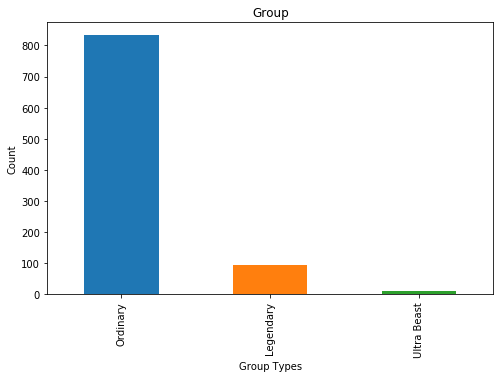

In [85]:
# Plot Group occurences to see the distributions
groupFig, groupAxes = plt.subplots(nrows=1, ncols=1)
groupCounts = data["Group"].value_counts()
groupAxe = groupCounts.plot(title="Group", kind="bar")
groupAxe.set(xlabel="Group Types", ylabel="Count")
plt.show()

### Plots of Pokemon vs. All Continuous Features & Generation vs. All Continuous Features

<Figure size 432x288 with 0 Axes>

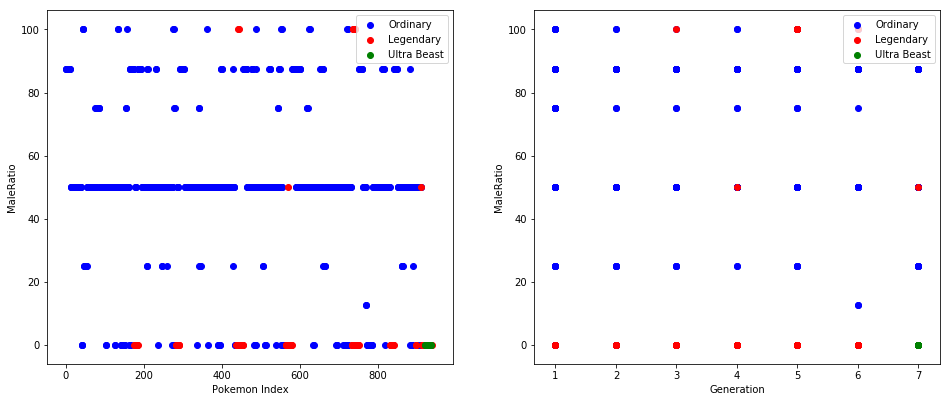

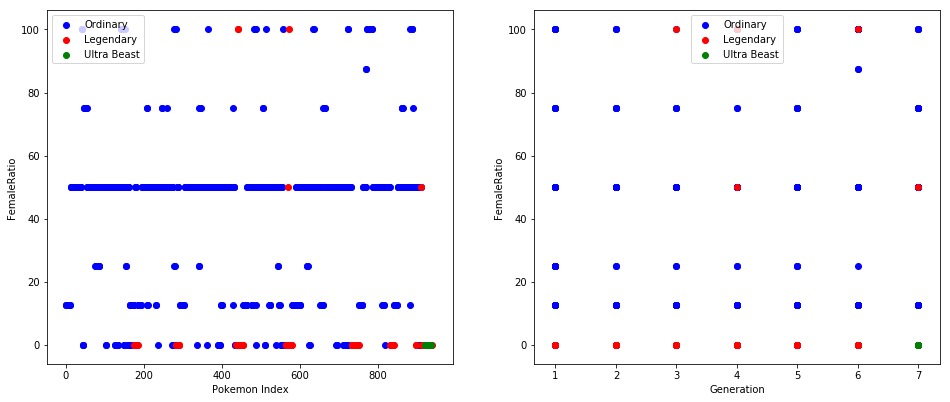

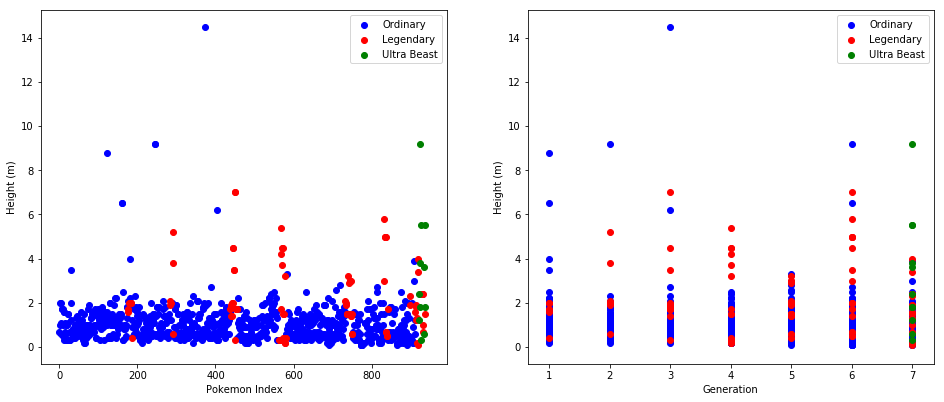

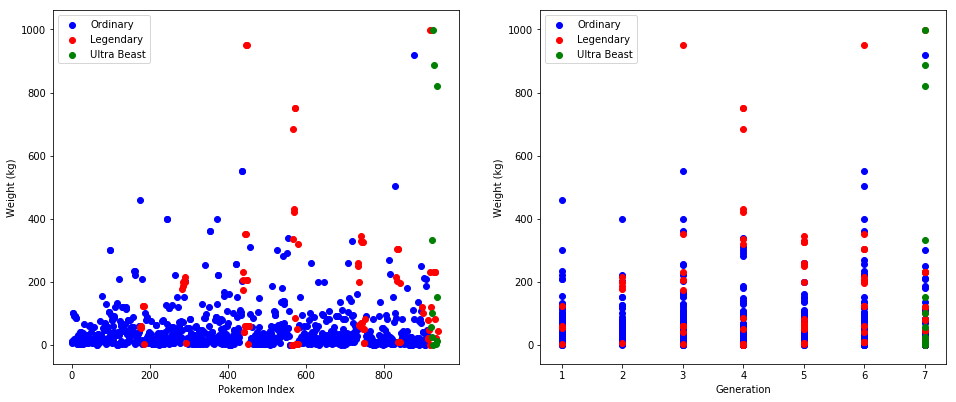

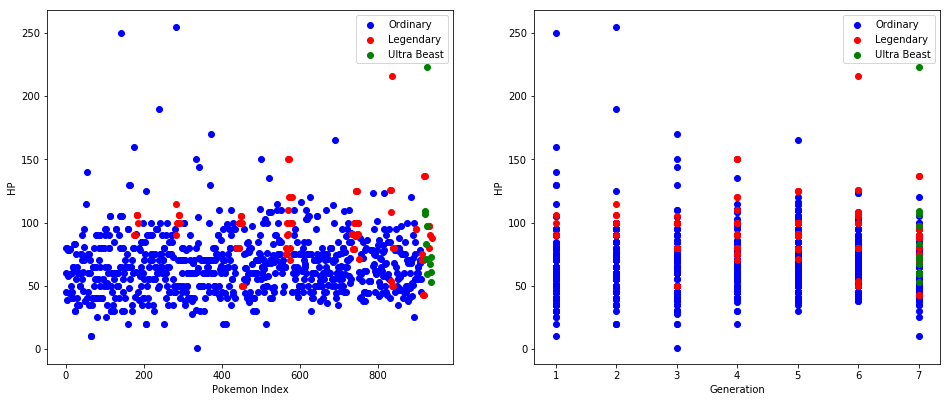

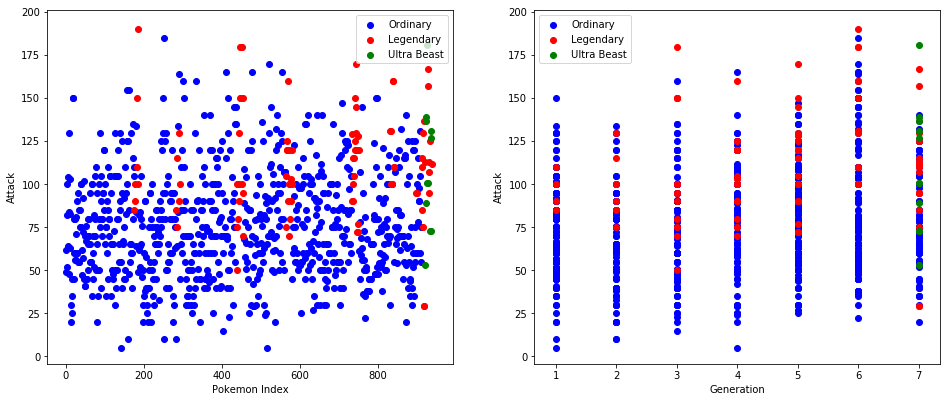

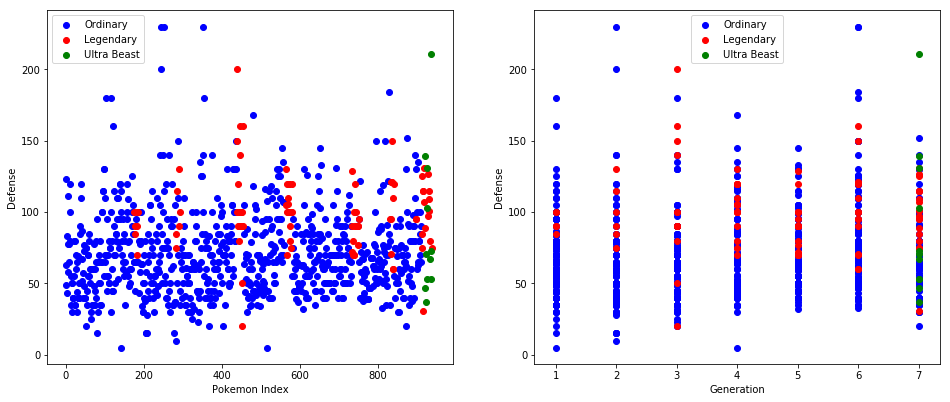

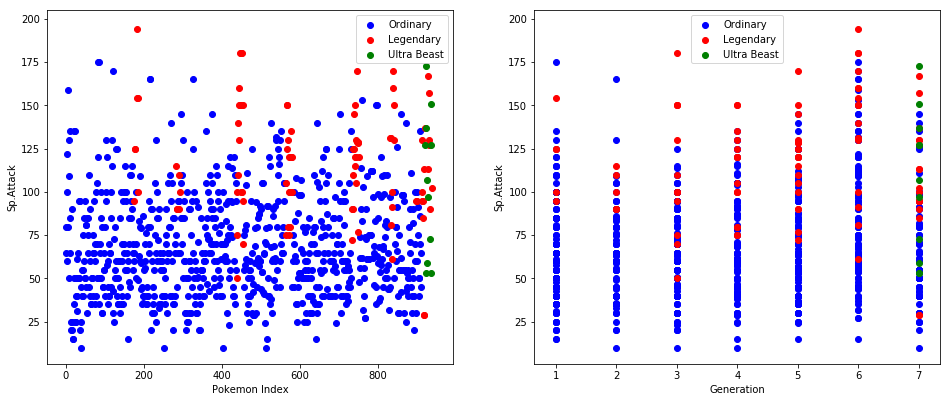

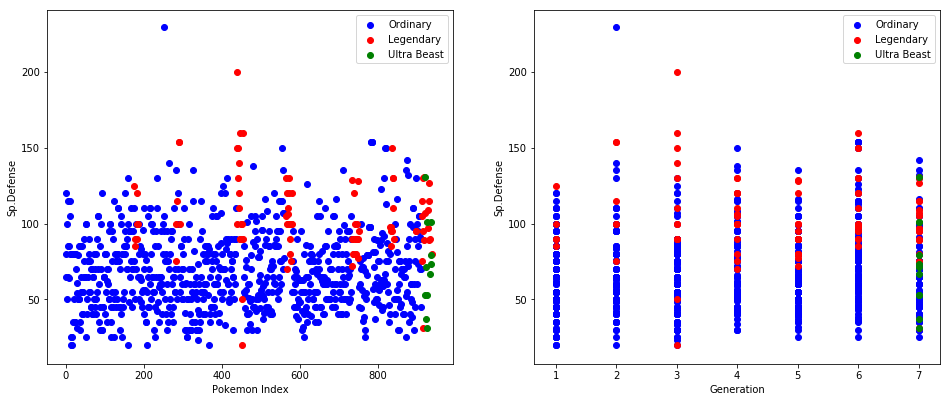

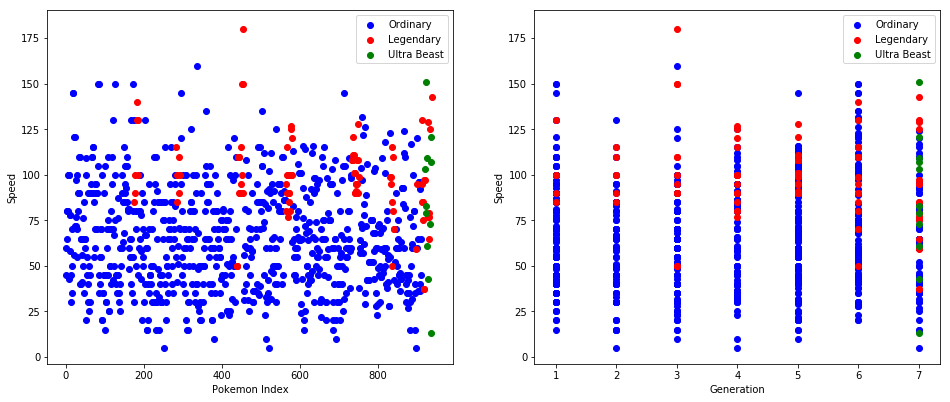

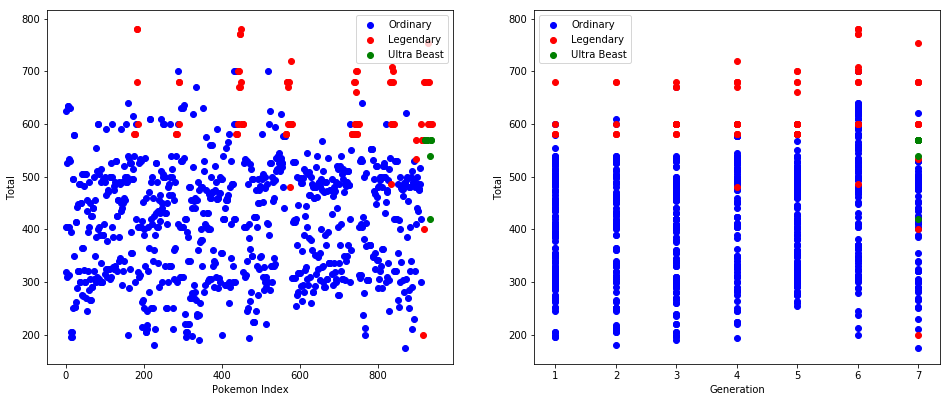

In [59]:
ordi = filterByValue(data, "Group", "Ordinary")
lg = filterByValue(data, "Group", "Legendary")
ub = filterByValue(data, "Group", "Ultra Beast")

continuousFeatures = data.select_dtypes(include=[np.int64, np.float64]).drop(["Generation", "Pokedex"], axis=1)
for feature in continuousFeatures:
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6.5))
    
    axes[0].set_xlabel("Pokemon Index")
    axes[0].set_ylabel(feature)
    axes[0].scatter(ordi.index, ordi[feature], c="b", label="Ordinary")
    axes[0].scatter(lg.index, lg[feature], c="r", label="Legendary")
    axes[0].scatter(ub.index, ub[feature], c="g", label="Ultra Beast")
    axes[0].legend(loc='best')
    
    axes[1].set_xlabel("Generation")
    axes[1].set_ylabel(feature)
    axes[1].scatter(ordi["Generation"], ordi[feature], c="b", label="Ordinary")
    axes[1].scatter(lg["Generation"], lg[feature], c="r", label="Legendary")
    axes[1].scatter(ub["Generation"], ub[feature], c="g", label="Ultra Beast")
    axes[1].legend(loc='best')
#     break

### Histograms of Continuous Features

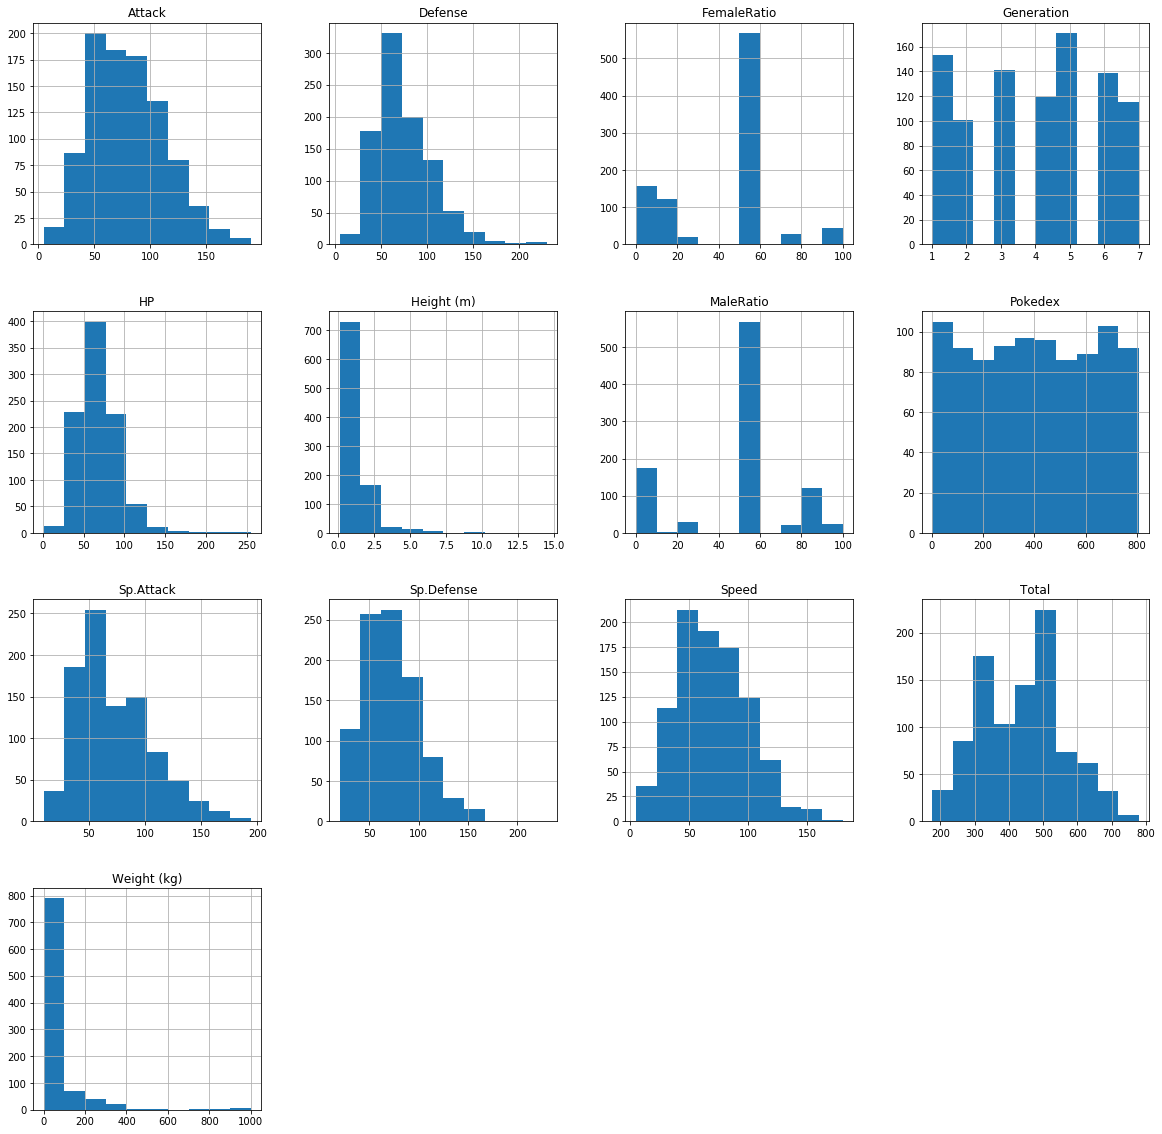

In [60]:
data.hist(figsize=(20,20))
plt.show()

We can see that features with uniform distribution may not contribute much to Decision Tree model because the model will be biased toward to those features since there is more entropy within those features.

### Box Plot of Total & Group

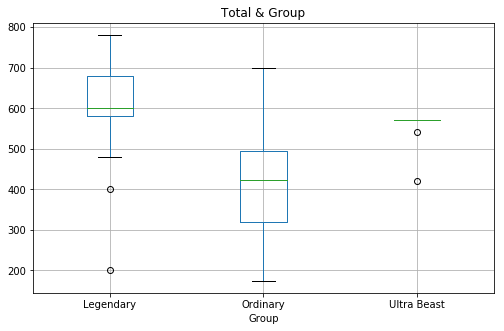

In [86]:
data.boxplot("Total", "Group")
plt.title("Total & Group")
plt.suptitle("")
plt.show()

<p> According to the boxplot above, we can see that despite having a small quanity in size, <b>Legendary Pokemon</b> has the highest <b>Total</b> stats compared to the other 2 groups.</p>

## Training & Test Data

In [82]:
target = "Group"
labels = data[target].unique()
labelColors = {"Ordinary": "b", "Legendary": "r", "Ultra Beast": "g"}

injectedData = ut.injectMinoritySample(["Ultra Beast", "Legendary"], "Group", data)
reducedData = injectedData.drop(DropColumns, axis=1)
training, test = ut.splitData(target, reducedData, 0.60)

## Decision Tree

In [149]:
# Use Decision Tree to train on the training set and predict on the test set
dtree = dt.DecisionTree(target, maxDepth=4)
dtree.train(training)
dtPred = dtree.classify(test.drop([target], axis=1))

Function "train" took 17.14 seconds to complete


In [150]:
dtMatrix = ut.buildConfusionMatrix(dtPred, test[target], labels)
dtPrecisions, dtRecalls = ut.getPrecisionsAndRecalls(dtMatrix, labels)
dtFScores = ut.computeFScores(dtPrecisions, dtRecalls)
"Error {0:.2f}%".format(ut.computeError(dtPred, test["Group"]) * 100)

'Error 0.89%'

### Decision Tree Confusion Matrix

In [151]:
dtMatrix

,Predicted Legendary,Predicted Ordinary,Predicted Ultra Beast,Total
Actual Legendary,337,4,0,341
Actual Ordinary,5,325,0,330
Actual Ultra Beast,0,0,339,339
Total,342,329,339,1010


### Decision Tree Depth

In [71]:
treeDepths = [i for i in range(10)]
depthErrors = []
for depth in treeDepths:
    learner = dt.DecisionTree(target, depth)
    learner.train(training)
    pred = learner.classify(test.drop([target], axis=1))
    err = ut.computeError(pred, test["Group"])
    depthErrors.append(err)

Function "train" took 0.00 seconds to complete
Function "train" took 3.96 seconds to complete
Function "train" took 11.94 seconds to complete
Function "train" took 17.02 seconds to complete
Function "train" took 11.13 seconds to complete
Function "train" took 14.92 seconds to complete
Function "train" took 23.55 seconds to complete
Function "train" took 19.75 seconds to complete
Function "train" took 31.69 seconds to complete
Function "train" took 16.17 seconds to complete


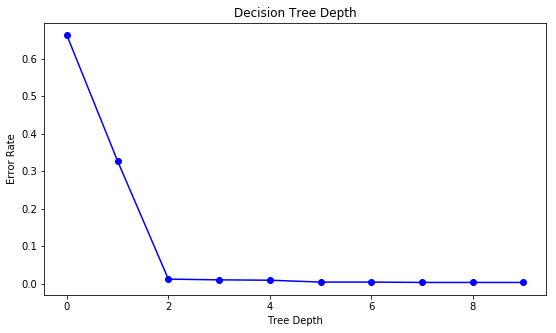

In [135]:
plt.plot(treeDepths, depthErrors, 'bo-')
plt.title("Decision Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Error Rate")
plt.show()

### Decision Tree ROC Curve

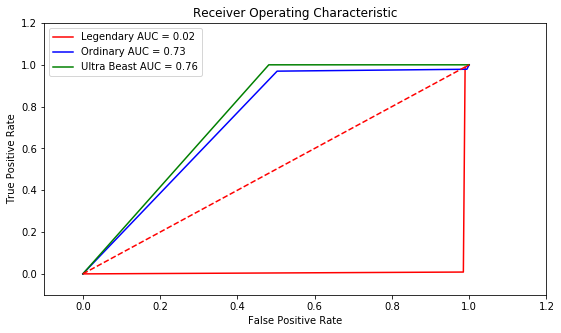

In [152]:
# For each label, treat other labels as "negative"
for label in labels:
    c = labelColors[label]
    fpr, tpr, thresholds = roc_curve(y_true=test[target], y_score=[v[1] for v in dtPred.values], pos_label=label)
    rocAuc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c, label='{0} AUC = {1:.2f}'.format(label, rocAuc))
    
plt.title('Receiver Operating Characteristic')
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Decision Tree K Fold Cross Validation from k=2 to k=10

In [90]:
dtKErrors = ut.kFoldCrossValidationResult(10, target, training, dtree)

Function "train" took 13.14 seconds to complete
Function "train" took 14.85 seconds to complete
Function "train" took 15.37 seconds to complete
Function "train" took 15.33 seconds to complete
Function "train" took 19.16 seconds to complete
Function "train" took 19.28 seconds to complete
Function "train" took 22.30 seconds to complete
Function "train" took 18.76 seconds to complete
Function "train" took 22.53 seconds to complete
Function "train" took 18.42 seconds to complete
Function "train" took 14.08 seconds to complete
Function "train" took 7.98 seconds to complete
Function "train" took 15.99 seconds to complete
Function "train" took 17.07 seconds to complete
Function "train" took 19.41 seconds to complete
Function "train" took 13.70 seconds to complete
Function "train" took 18.38 seconds to complete
Function "train" took 16.08 seconds to complete
Function "train" took 16.69 seconds to complete
Function "train" took 9.25 seconds to complete
Function "train" took 11.74 seconds to com

### Compute the and means, variances, and standard deviations of the k fold cross validation result

In [137]:
means = [sum(e) / len(e) for e in dtKErrors]
stds =  []
variances = []

for e, m in zip(dtKErrors, means):
    v = sum(map(lambda x: (x - m)**2, e)) / len(e)
    s = math.sqrt(v)
    variances.append(v)
    stds.append(s)

### Plot the error rates represented by the mean, variance, and standard deviation

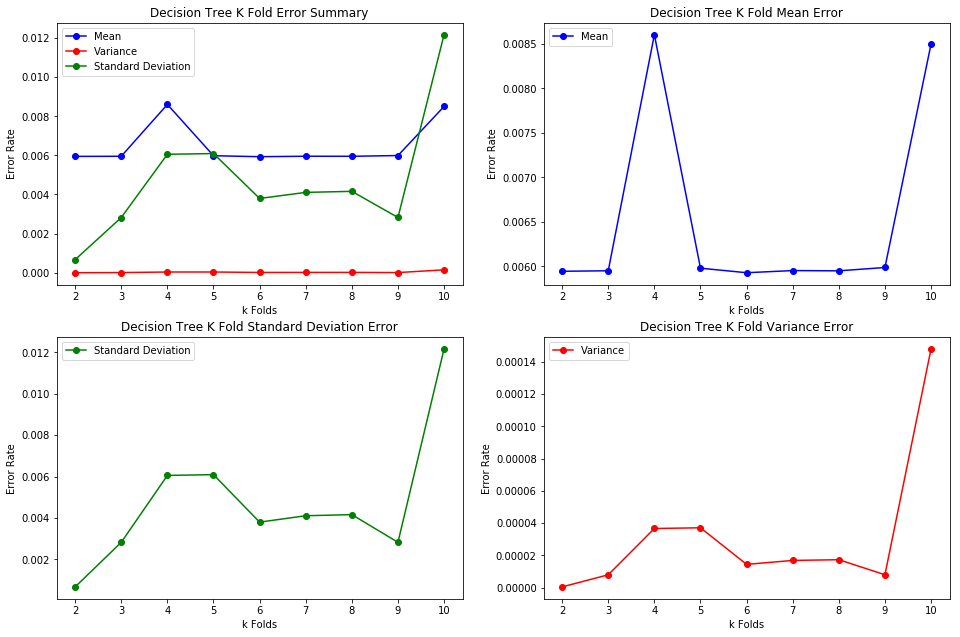

In [143]:
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
figure.subplots_adjust(top=1.5, bottom=0.5)

axes[0, 0].plot([i for i in range(2, 11)], means, "bo-", label="Mean")
axes[0, 0].plot([i for i in range(2, 11)], variances, "ro-", label="Variance")
axes[0, 0].plot([i for i in range(2, 11)], stds, "go-", label="Standard Deviation")
axes[0, 0].set_title("Decision Tree K Fold Error Summary")
axes[0, 0].set_xlabel("k Folds")
axes[0, 0].set_ylabel("Error Rate")
axes[0, 0].legend(loc="best")

axes[0, 1].plot([i for i in range(2, 11)], means, "bo-", label="Mean")
axes[0, 1].set_title("Decision Tree K Fold Mean Error")
axes[0, 1].set_xlabel("k Folds")
axes[0, 1].set_ylabel("Error Rate")
axes[0, 1].legend(loc="best")

axes[1, 1].plot([i for i in range(2, 11)], variances, "ro-", label="Variance")
axes[1, 1].set_title("Decision Tree K Fold Variance Error")
axes[1, 1].set_xlabel("k Folds")
axes[1, 1].set_ylabel("Error Rate")
axes[1, 1].legend(loc="best")

axes[1, 0].plot([i for i in range(2, 11)], stds, "go-", label="Standard Deviation")
axes[1, 0].set_title("Decision Tree K Fold Standard Deviation Error")
axes[1, 0].set_xlabel("k Folds")
axes[1, 0].set_ylabel("Error Rate")
axes[1, 0].legend(loc="best")
plt.show()

## Naive Bayes

In [97]:
# Use Naive Bayes to train on the training set and predict on the test data set
nBayes = nb.NaiveBayes(target, labels)
nBayes.train(training)
nbPred = nBayes.classify(test.drop([target], axis=1))

Function "train" took 4.82 seconds to complete
Function "classify" took 30.53 seconds to complete


In [98]:
nbMatrix = ut.buildConfusionMatrix(nbPred, test[target], reducedData[target].unique())
nbPrecisions, nbRecalls = ut.getPrecisionsAndRecalls(nbMatrix, reducedData[target].unique())
nbFScores = ut.computeFScores(nbPrecisions, nbRecalls)
nbSens, nbSpec = ut.getSensitivityAndSpecifiicy(nbMatrix, reducedData[target].unique())
"Error: {0:.2f}%".format(ut.computeError(nbPred, test["Group"]) * 100)

'Error: 20.69%'

### Naive Bayes Confustion Matrix

In [101]:
nbMatrix

,Predicted Legendary,Predicted Ordinary,Predicted Ultra Beast,Total
Actual Legendary,195,4,142,341
Actual Ordinary,0,267,63,330
Actual Ultra Beast,0,0,339,339
Total,195,271,544,1010


### Naive Bayes ROC Curve

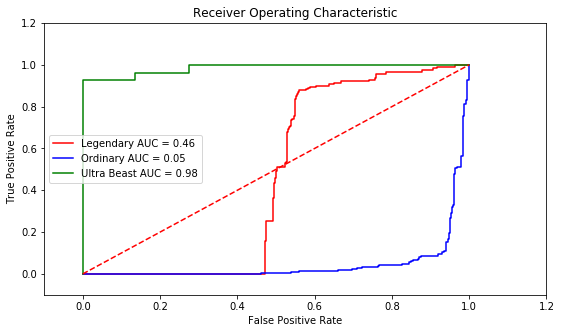

In [132]:
# For each label, treat other labels as "negative"
for label in labels:
    c = labelColors[label]
    fpr, tpr, thresholds = roc_curve(y_true=test[target], y_score=[v[1] for v in nbPred.values], pos_label=label)
    rocAuc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c, label='{0} AUC = {1:.2f}'.format(label, rocAuc))
    
plt.title('Receiver Operating Characteristic')
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Perform K Fold Cross Validations from k=2 to k=10

In [103]:
nbKErrors = ut.kFoldCrossValidationResult(10, target, training, nBayes)

Function "train" took 3.41 seconds to complete
Function "classify" took 17.57 seconds to complete
Function "train" took 3.28 seconds to complete
Function "classify" took 18.39 seconds to complete
Function "train" took 4.59 seconds to complete
Function "classify" took 11.05 seconds to complete
Function "train" took 3.92 seconds to complete
Function "classify" took 14.94 seconds to complete
Function "train" took 4.01 seconds to complete
Function "classify" took 5.43 seconds to complete
Function "train" took 4.95 seconds to complete
Function "classify" took 15.52 seconds to complete
Function "train" took 4.24 seconds to complete
Function "classify" took 7.05 seconds to complete
Function "train" took 3.88 seconds to complete
Function "classify" took 7.19 seconds to complete
Function "train" took 4.52 seconds to complete
Function "classify" took 11.39 seconds to complete
Function "train" took 5.42 seconds to complete
Function "classify" took 6.25 seconds to complete
Function "train" took 4.

### Compute the and means, variances, and standard deviations of the k fold cross validation result

In [133]:
means = [sum(e) / len(e) for e in nbKErrors]
stds =  []
variances = []

for e, m in zip(nbKErrors, means):
    v = sum(map(lambda x: (x - m)**2, e)) / len(e)
    s = math.sqrt(v)
    variances.append(v)
    stds.append(s)

### Plot the error rates represented by the mean, variance, and standard deviation

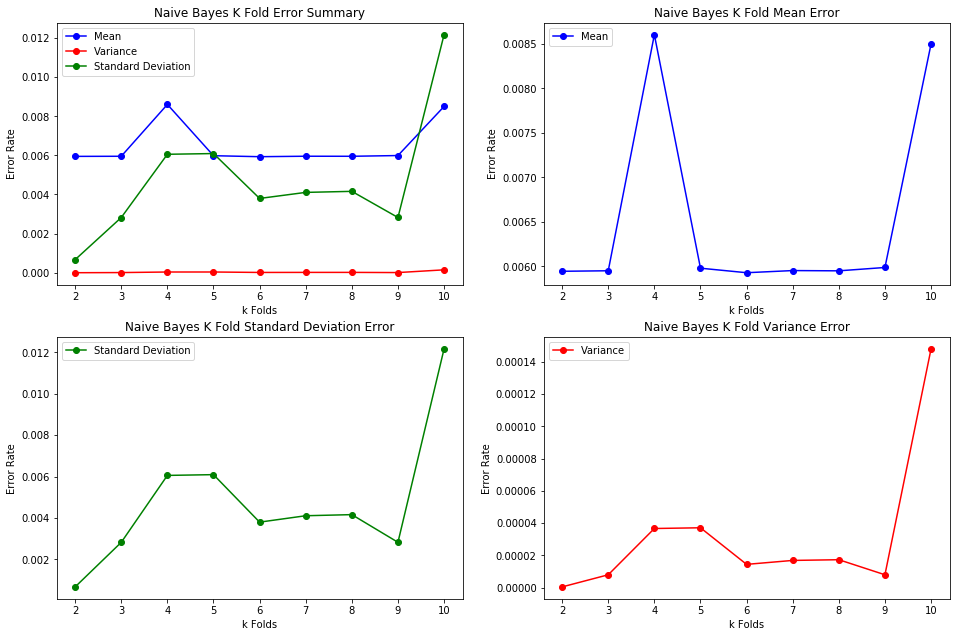

In [142]:
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
figure.subplots_adjust(top=1.5, bottom=0.5)

axes[0, 0].plot([i for i in range(2, 11)], means, "bo-", label="Mean")
axes[0, 0].plot([i for i in range(2, 11)], variances, "ro-", label="Variance")
axes[0, 0].plot([i for i in range(2, 11)], stds, "go-", label="Standard Deviation")
axes[0, 0].set_title("Naive Bayes K Fold Error Summary")
axes[0, 0].set_xlabel("k Folds")
axes[0, 0].set_ylabel("Error Rate")
axes[0, 0].legend(loc="best")

axes[0, 1].plot([i for i in range(2, 11)], means, "bo-", label="Mean")
axes[0, 1].set_title("Naive Bayes K Fold Mean Error")
axes[0, 1].set_xlabel("k Folds")
axes[0, 1].set_ylabel("Error Rate")
axes[0, 1].legend(loc="best")

axes[1, 1].plot([i for i in range(2, 11)], variances, "ro-", label="Variance")
axes[1, 1].set_title("Naive Bayes K Fold Variance Error")
axes[1, 1].set_xlabel("k Folds")
axes[1, 1].set_ylabel("Error Rate")
axes[1, 1].legend(loc="best")

axes[1, 0].plot([i for i in range(2, 11)], stds, "go-", label="Standard Deviation")
axes[1, 0].set_title("Naive Bayes K Fold Standard Deviation Error")
axes[1, 0].set_xlabel("k Folds")
axes[1, 0].set_ylabel("Error Rate")
axes[1, 0].legend(loc="best")
plt.show()

### Playground

In [ ]:
r = ut.injectMinoritySample(["Ultra Beast", "Legendary"], "Group", data)

In [ ]:
r[target].value_counts()

In [141]:
# Get data profile
profile = pdp.ProfileReport(dataWithDummies)
profile.to_file("Profile.html")
profile = None
gc.collect()